<img src='./img/logoline_12000.png' align='right' width='100%'></img>

<br>

# Climate indices

### About

In this tutorial we will compute the average wind chill index over Europe for 15 December at 12:00 UTC using the reanalysis dataset [ERA5-Land hourly data from 1950 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview). The wind chill index is a metric in temperature-like units, e.g. Kelvin or °C, and represents the degree of 'chill' that your skin senses. The wind chill factor quantifies the effect of wind on the temperature humans perceive. Thus, the wind chill is calculated with the help of a standard formula based on the air temperature in degrees Celsius and the wind speed at 10m in kilometres per hour.
Since 2001, Canada, the United States and the United Kingdom have implemented the new wind chill index which is defined with the following formula:

$\textit{T}_{WC} = 13.12 + 0.6215\textit{T}_{a} - 11.37\upsilon^{0.16} + 0.3965\textit{T}_{a}\upsilon^{0.16}$

where:
- $\textit{T}_{WC}$ = wind chill index
- $\textit{T}_{a}$ = air temperature in degrees Celsius
- $\upsilon$ = wind speed at 10 m standard anemometer height, in kilometres per hour

<br>

The resulting wind chill index has the unit `degrees Celsius` and tells you how the air temperature feels, depending on how strong the wind blows. The wind chill index can be categorised into the following classes:
* `< -25 °C`: Cold
* `< -35 °C`: Very Cold
* `< -60 °C`: Danger of frostbite
* `> -60 °C`: Great danger of frostbite

In the chart below, you see that depending on how strong the wind blows, in can already feel `very cold` for example starting from an air temperature of -12 degrees Celsius.

<img src='./img/Windchill_effect_en.svg' width='40%'></img>
<br>

RicHard-59, CC BY-SA 3.0 <https://creativecommons.org/licenses/by-sa/3.0>, via Wikimedia Commons

<br>

### Notebook outline

The notebook has three sections which guide you through the individiual steps of preparing data and calculating and visualizing the wind chill index:

* [1 - Data preparation](#data_preparation)
* [2 - Calculation of wind speed at 10m from 10 m U and V wind components](#wind_speed)
* [3 - Calculation of the wind chill index](#wind_chill_europe)

### Data

This notebook introduces you to the ERA5-Land hourly data on single levels. The data has the following specifications:

> **Data**: `ERA5-Land hourly data from 1950 to present` <br>
> **Temporal coverage**: `15 December at 12:00 from 1981 to 2020` <br>
> **Spatial coverage**: `Europe` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5-land_hourly)

Get [here](./101_c3s_data_intro.ipynb) more information about climate reanalysis data in general including an overview of they different dataset types.

<br>

<hr>

#### Load libraries

In [34]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

import math

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

#### Load helper functions

In [ ]:
%run ./functions.ipynb

<hr>

## <a id='data_prepare'></a>1. Data preparation

The example below will show you how to calculate the average wind chill index over Europe for a specific day and hour in December.

### Load the dataset

The first step is to open the dataset with the function `open_dataset()` of the Python library [xarray](http://xarray.pydata.org/en/stable/). xarray is a Python library that makes the handling of multi-dimensional meteorological and climate data as well as `netCDF` data very efficient. The data file is available under the path: `./data/era5-land_eur_1981_2020.nc`. 

The `open_dataset()` function returns a `xarray.Dataset` object, which can hold one or more `xarray.DataArray` objects, which are aligned on the same dimensions. The loaded `xarray.Dataset` has the following specifications: 
* three dimensions: `latitude`, `longitude` and `time` and
* 3 data variables: `u10`, `v10`, `t2m`

In [4]:
file = './data/era5-land_eur_1981_2020.nc'

In [5]:
era5_land_eur_1981_2020 = xr.open_dataset(file)
era5_land_eur_1981_2020

<xarray.Dataset>
Dimensions:    (longitude: 401, latitude: 251, time: 40)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-28 11:20:06 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

<br>

The next step is to load the data variables `t2m`, `u10` and `v10` as `xarray.DataArray` objects. You can load a data variable from an `xarray.Dataset` by specifying the name of the data variable (`t2m`) in square brackets `[]`. A `xarray.DataArray` object is a labeled, multi-dimensional array, which you can modify and apply operations on. Once the `xarray.DataArray` is loaded, you see additional `attributes` of the data variable, such as `units` and `long_name`.

Let us start with the variable `t2m`. The attributes show you that the variable is the 2m air temperature in Kelvin.

In [6]:
t2m = era5_land_eur_1981_2020['t2m']
t2m

<xarray.DataArray 't2m' (time: 40, latitude: 251, longitude: 401)>
[4026040 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

<br>

The next step is to load the two other variables `u10` and `v10`, which are the 10 meter U and V wind components in m / s.

In [10]:
u10 = era5_land_eur_1981_2020['u10']
u10

<xarray.DataArray 'u10' (time: 40, latitude: 251, longitude: 401)>
[4026040 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre U wind component

In [9]:
v10 = era5_land_eur_1981_2020['v10']
v10

<xarray.DataArray 'v10' (time: 40, latitude: 251, longitude: 401)>
[4026040 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00
Attributes:
    units:      m s**-1
    long_name:  10 metre V wind component

<br>

Now, all the data required to compute the wind chille index are loaded. However, before we can proceed to calculate the wind chill index, we first have to compute the `wind speed at 10m`. The ERA5-Land reanalysis data does not offer `wind speed` as parameter, but with the help of the U and V components, we can easily compute the wind speed, which we will do in the next section.

<br>

## <a id='wind_speed'></a>2. Calculate wind speed at 10m from 10 m U and V wind components

The wind speed can be computed from both, the zonal (U) and the meridional (V) wind components with the following formula:

$\sqrt{(u^{2} + v^{2})}$

The unit of the resulting wind speed is m/s, as both components are provided in this unit.

The formula can implemented in Python as follows: taking the square (`**2`) of both variables, `u10` and `v10` and then applying the square root with `**0.5`.

In [11]:
windspeed = (u10**2 + v10**2)**0.5
windspeed

<xarray.DataArray (time: 40, latitude: 251, longitude: 401)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
         2.5300028],
        [      nan,       nan,       nan, ..., 2.6178713, 2.4882226,
               nan],
        [      nan,       nan,       nan, ..., 2.13668  , 2.0393589,
         1.9724407],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
         7.5970745],
        [      nan,       nan,       nan, ..., 7.4682245, 7.148128 ,
               nan],
        [      nan,       nan,       nan, ..., 5.7350645, 5.558745 ,
         5.2687345],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
         2.8508277],
        [      nan,       nan,       nan, ..., 3.051753 , 2.7900507,
               nan],
        [      nan,       nan,       nan, ..., 2.3551228, 2.1163394,
         1.8476912],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00

<br>

With the two functions `min()` and `max()`, you can see the minimum and maximum wind speed in m/s on 15 December at 12:00 during the period 1981 to 2020.

In [13]:
windspeed.min(), windspeed.max()

(<xarray.DataArray ()>
 array(0.00071163, dtype=float32), <xarray.DataArray ()>
 array(19.959562, dtype=float32))

<br>

Now, the wind speed information can be used to calculate the wind chill index, together with information on 2m air temperature.

<br>

## <a id='wind_chill'></a>3. Calculation of the wind chill index

As a reminder, the wind chill index formula is the following:

$\textit{T}_{WC} = 13.12 + 0.6215\textit{T}_{a} - 11.37\upsilon^{0.16} + 0.3965\textit{T}_{a}\upsilon^{0.16}$

where:
- $\textit{T}_{WC}$ = wind chill index
- $\textit{T}_{a}$ = air temperature in degrees Celsius
- $\upsilon$ = wind speed at 10 m standard anemometer height, in kilometres per hour

To calculate the wind chill index $\textit{T}_{WC}$, we first have to ensure that our data is in the correct units. We need to convert the wind speed from m/s to km/h, and the 2m air temperature from Kelvin to degrees Celsius. 

You can convert the wind speed in m/s to km/h by simply multiplying it with 3.6 (3600 s to 1 h / 1000 m to 1 km).

In [16]:
windspeed_kmh = windspeed * 3.6
windspeed_kmh

<xarray.DataArray (time: 40, latitude: 251, longitude: 401)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,  9.10801  ],
        [       nan,        nan,        nan, ...,  9.424336 ,
          8.957602 ,        nan],
        [       nan,        nan,        nan, ...,  7.6920476,
          7.3416915,  7.100786 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan, 27.349468 ],
        [       nan,        nan,        nan, ..., 26.885607 ,
         25.733261 ,        nan],
        [       nan,        nan,        nan, ..., 20.646233 ,
         20.01148  , 18.967443 ],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan, 10.2629795],
        [       nan,        nan,        nan, ..., 10.986311 ,
         10.044183 ,        nan],
        [       nan,        nan,        nan, ...,  8.478442 ,
          7.6188216,  6.651688 ],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00

<br>

For converting air temperature in Kelvin to degrees Celsius, you simply subtract 273.15 from the Kelvin temperature.

In [15]:
t2m_degC = t2m - 273.15
t2m_degC

<xarray.DataArray 't2m' (time: 40, latitude: 251, longitude: 401)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan, -6.864197  ],
        [        nan,         nan,         nan, ..., -7.5708923 ,
         -7.789276  ,         nan],
        [        nan,         nan,         nan, ..., -9.041504  ,
         -9.139008  , -9.406525  ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan, -6.1147766 ],
        [        nan,         nan,         nan, ..., -6.556366  ,
         -6.630493  ,         nan],
        [        nan,         nan,         nan, ..., -7.1300964 ,
         -7.138153  , -7.1421814 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan, -1.2460327 ],
        [        nan,         nan,         nan, ..., -1.0881042 ,
         -1.148529  ,         nan],
        [        nan,         nan,         nan, ..., -1.2758484 ,
         -1.3105164 , -1.3886719 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00

<br>

In a next step, you can calculate the wind chill index with the following equation:
$\textit{T}_{WC} = 13.12 + 0.6215\textit{T}_{a} - 11.37\upsilon^{0.16} + 0.3965\textit{T}_{a}\upsilon^{0.16}$

In [17]:
twc = 13.12 + (0.6215*t2m_degC) - (11.37*(windspeed_kmh**0.16)) + (0.3965*t2m_degC*(windspeed_kmh**0.16))
twc

<xarray.DataArray (time: 40, latitude: 251, longitude: 401)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan, -11.21251  ],
        [        nan,         nan,         nan, ..., -12.16283  ,
         -12.254976 ,         nan],
        [        nan,         nan,         nan, ..., -13.227031 ,
         -13.186785 , -13.388373 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan, -14.102015 ],
        [        nan,         nan,         nan, ..., -14.60892  ,
         -14.539192 ,         nan],
        [        nan,         nan,         nan, ..., -14.356194 ,
         -14.251509 , -14.060783 ],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,  -4.8745537],
        [        nan,         nan,         nan, ...,  -4.8731933,
          -4.698762 ,         nan],
        [        nan,         nan,         nan, ...,  -4.391396 ,
          -4.148429 ,  -3.885438 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 1981-12-15T12:00:00 ... 2020-12-15T12:00:00

<br>

In a last step, we want to build the average `wind chill index` for 15 December at 12:00 UTC for the 41 year period from 1981 to 2020. You can simply apply the function `mean()` and specify as dimension `time`. This operation averages all values for each pixel across the dimension time.

In [18]:
twc_mean = twc.mean(dim='time')
twc_mean

<xarray.DataArray (latitude: 251, longitude: 401)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
        -9.488675],
       [      nan,       nan,       nan, ..., -9.603178, -9.580095,
              nan],
       [      nan,       nan,       nan, ..., -9.445845, -9.409012,
        -9.342304],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -10.0 -9.9 -9.8 -9.7 ... 29.7 29.8 29.9 30.0
  * latitude   (latitude) float32 60.0 59.9 59.8 59.7 ... 35.3 35.2 35.1 35.0

<br>

As a final step, let us plot the average wind chill index in degrees Celsius for 15 December at 12:00 UTC over Europe. You can make use of the function `visualize_pcolormesh()` which is part of the functions library. This function combines matplotlib's `pcolormesh()` function with the Cartopy library for projections.

Feel free to modify some keywords:
* `color_scale`: we chose `viridis`. Feel free to try out other [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) offered by matplotlib
* `vmin`, `vmax`: with `xarray.DataArray.min()` and `xarray.DataArray.max()` you can retrieve the minimum and maximum values in order to adjust the color range

(<Figure size 1440x720 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7ff0ceba9c18>)

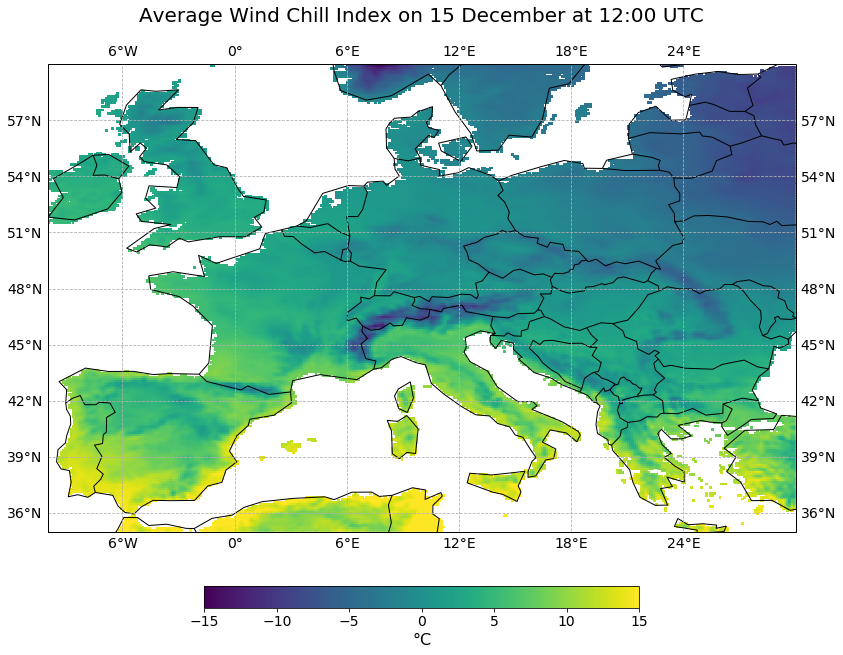

In [33]:
visualize_pcolormesh(data_array = twc_mean,
                    longitude = twc_mean.longitude,
                    latitude = twc_mean.latitude,
                    projection = ccrs.PlateCarree(),
                    color_scale = 'viridis',
                    unit = '°C',
                    long_name = 'Average Wind Chill Index on 15 December at 12:00 UTC\n',
                    vmin = -15,
                    vmax = 15,
                    set_global=False,
                    lonmin=twc_mean.longitude.min(),
                    lonmax=twc_mean.longitude.max(),
                    latmin=twc_mean.latitude.min(),
                    latmax=twc_mean.latitude.max())

<br>

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>